# Final exam

**For this exam, feel free to re-use any code from the previous lab notebooks.**

#### Tasks
- Use accelerator data to construct a neural network surrogate model, train that model, and demonstrate that it accurately models the data
- Use Bayesian optimization to optimize the function and determine the best operational parameters

## Setting up the environment

In [2]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

#add PyTorch and TorchVision (used for cropping etc.)
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import torch
import scipy.constants as cst

def propagate(bunch_n_particles=1000, bunch_rms_z=1.e-3,
        bunch_mean_E=100e6, bunch_rms_E=0.01e6,
        linac_final_E=1000e6, linac_rf_frequency=1.3e9, linac_phase=0.,
        arc_r56=0, arc_r566=0 ):
        """
        Compute the propagation of an electron bunch through the linac + arc

        Parameters:
        -----------
        bunch_n_particles: int
            Number of particles in the bunch

        bunch_rms_z: float (in meters)
            The RMS size of the bunch along z (before entering the linac)

        bunch_mean_E: float (in eV)
            The mean energy of the bunch (before entering the linac)

        bunch_rms_E: float (in eV)
            The RMS energy spread of the bunch (before entering the linac)

        linac_final_E: float (in eV)
            The (mean) energy of the bunch at the end of the linac

        linac_rf_frequency: float (in Hz)
            The frequency of the RF cavity of the linac

        linac_phase: float (in degrees)
            The phase of the bunch in the linac

        arc_r56, arc_r566: floats (in meter)
            The coeficients of the energy-dependent delay induced by the arc:
            z -> z + r56*delta + t566*delta**2

        Returns
        -------
        rms_z : float (meters)
            Longitudinal bunch length

        rms_delta : float (None)
            RMS bunch energy deviation from reference

        """
        # Generate the bunch before the linac, with random Gaussian distribution
        bunch_z = torch.randn(bunch_n_particles) * bunch_rms_z
        bunch_delta = torch.randn(bunch_n_particles) * bunch_rms_E / bunch_mean_E

        # Analytical change in relative energy spread (delta) after the bunch propagates in the linac
        # $\delta \rightarrow \delta \frac{E_0}{E_1} + (1- \frac{E_0}{E_1})\frac{\cos(kz +\phi)}{\cos(\phi)}$
        k = 2*cst.pi*linac_rf_frequency/cst.c
        phi = linac_phase * 2*cst.pi/360. # Convert from degrees to radians
        E0_over_E1 = bunch_mean_E/linac_final_E
        bunch_delta = E0_over_E1 * bunch_delta.clone() + \
          (1. - E0_over_E1)*(torch.cos(k*bunch_z + phi)/torch.cos(phi) -1)

        # Analytical change in position (z) after the bunch propagates in the arc
        # z -> z + r56*delta + t566*delta**2
        bunch_z = bunch_z + arc_r56*bunch_delta + \
                        arc_r566*bunch_delta**2

        #add noise to the observations
        bunch_delta += torch.randn(1)*1e-4
        bunch_z += torch.randn(1)*1e-3

        return torch.hstack((bunch_z.std(), bunch_delta.std())).reshape(1,-1)

## Generate dataset

The code below generates samples from "simulations" of a beam propagating through a linac followed by an arc:
- The input to the simulator are the linac's phase, the arc's R56 coefficient, and the beam final (mean) energy.
- The output of the simulator are the bunch length (in meters) and the bunch's RMS energy spread.

In [4]:
#generate input samples
n = 10000
torch.manual_seed(0)
inputs = torch.rand((n, 3))

#phase +/- 50 deg
inputs[:, 0] = inputs[:, 0] * 100.0 - 50.0

#r56 +/- 0.5
inputs[:,1] = inputs[:,1] - 0.5

#final energy [800,1300]*1e6
inputs[:,2] = (inputs[:,2] * 500.0 + 800.0) * 1e6

print('Inputs:')
print(inputs)

outputs = []
for i in range(n):
    outputs += [propagate(linac_phase = inputs[i][0],
                                        arc_r56 = inputs[i][1],
                                        linac_final_E = inputs[i][2])]

outputs = torch.vstack(outputs)

print('Outputs:')
print(outputs)

Inputs:
tensor([[-3.7434e-01,  2.6822e-01,  8.4424e+08],
        [-3.6797e+01, -1.9258e-01,  1.1170e+09],
        [-9.9066e-01,  3.9644e-01,  1.0278e+09],
        ...,
        [ 2.6369e+01, -4.5239e-01,  8.7906e+08],
        [-1.9793e+01, -1.4001e-02,  1.1869e+09],
        [-4.6165e+00, -1.8174e-01,  8.3491e+08]])
Outputs:
tensor([[0.0010, 0.0005],
        [0.0026, 0.0189],
        [0.0011, 0.0006],
        ...,
        [0.0063, 0.0118],
        [0.0009, 0.0089],
        [0.0006, 0.0021]])


## Regression with a neural network

**Task:**
    Appropriately normalize the input data, and standardize the output data.

**Task:**
    Create and train a neural network to model this data, i.e. for each data point, the neural network should take the above 3 (normalized) input features and predict the above 2 (normalized) output features.
    
In order to show that the neural network works as expected and that the training roughly converged, plot the evolution of the loss function - both for the training dataset and test dataset - during training. (Use the first 7000 data points as the training set, and the remaining 3000 data points as the test set.)
</div>

### Normalize inputs and outputs

In [16]:
inputs, outputs

(tensor([[-3.7434e-01,  2.6822e-01,  8.4424e+08],
         [-3.6797e+01, -1.9258e-01,  1.1170e+09],
         [-9.9066e-01,  3.9644e-01,  1.0278e+09],
         ...,
         [ 2.6369e+01, -4.5239e-01,  8.7906e+08],
         [-1.9793e+01, -1.4001e-02,  1.1869e+09],
         [-4.6165e+00, -1.8174e-01,  8.3491e+08]]),
 tensor([[0.0010, 0.0005],
         [0.0026, 0.0189],
         [0.0011, 0.0006],
         ...,
         [0.0063, 0.0118],
         [0.0009, 0.0089],
         [0.0006, 0.0021]]))

In [17]:
inputs.shape, outputs.shape

(torch.Size([10000, 3]), torch.Size([10000, 2]))

In [18]:
def normalize(tensor):
  return (tensor - tensor.min(dim=0).values) / (tensor.max(dim=0).values - tensor.min(dim=0).values)

In [19]:
inputs_norm = normalize(inputs)
outputs_norm = normalize(outputs)

# check tensors in [0, 1]
print(inputs_norm.min(), inputs_norm.max())
print(outputs_norm.min(), outputs_norm.max())

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


In [53]:
7000/1024

6.8359375

### Set up training and testing data

In [87]:
n_train = 7000
n_test = 3000

#create test and train datasets
train_x = inputs[:n_train]
train_y = outputs[:n_train]

test_x = inputs[:n_test]
test_y = outputs[:n_test]

### Model architechture

In [88]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()

        hidden_size = 20
        # Define layers
        self.linear1 = nn.Linear(3, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, 2)

        self.tanh = nn.Tanh()  # Activation function

    def forward(self, x):
        x = self.tanh(self.linear1(x))
        x = self.tanh(self.linear2(x))
        x = self.tanh(self.linear3(x))
        x = self.tanh(self.linear4(x))
        x = self.tanh(self.linear5(x))

        x = self.linear6(x)

        return x

In [89]:
def train_model(model):
    model.train()
    optimizer.zero_grad()
    output = model(train_x)
    loss = F.mse_loss(output, train_y)
    loss.backward()
    #step optimizer
    optimizer.step()

    return loss.item()

In [90]:
def test_model(model):
    model.eval()
    with torch.no_grad():
      output = model(test_x)
      loss = F.mse_loss(output, test_y)
    return loss.item()

### Create model, optimizer, train and test simultaneously

In [97]:
model = NNModel()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

train_losses = []
test_losses = []
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    train_losses.append(train_model(model))
    test_losses.append(test_model(model))

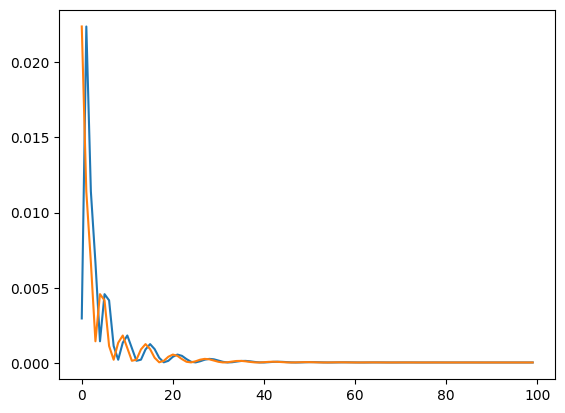

In [98]:
fig, ax = plt.subplots()
ax.plot(train_losses)
ax.plot(test_losses)

## Bayesian optimization

**Task:**
    Use Bayesian optimization to minimize the bunch length (i.e. the first of the 2 features that are returned by `simple_linarc`) with respect to phase, r56, and final_energy (i.e. the 3 input features that we passed to `simple_linarc` when previously generating the dataset for the neural network). DO NOT USE XOPT.
    
Use 3 randomly generated points in the input domain (shown in the comments above) as the initial dataset on which to fit the initial Gaussian Process (at the beginning of Bayesian optimization). Then, at each iteration of Bayesian optimization, call the `propagate` function on the new candidate point.
    
Run 6 steps of Bayesian optimization and print the values of the bunch length obtained at each iteration. What is the best value obtained so far?

In [99]:
!pip install botorch==0.12.0 gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 828.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
#import packages required for BO
import torch

from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood


In [25]:
train_x = inputs_norm[:3]  # not normalized
train_y = outputs_norm[:3] # not normalized

In [37]:
train_y[:, 0].unsqueeze(dim=-1)

tensor([[0.0632],
        [0.1609],
        [0.0665]])

In [39]:
train_x

tensor([[0.4963, 0.7682, 0.0885],
        [0.1320, 0.3074, 0.6341],
        [0.4902, 0.8965, 0.4557]])

In [40]:
niter = 6
bounds = torch.stack([torch.zeros(1), torch.ones(1)]).to(torch.double)

for _ in range(niter):
  gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y[:, 0]),
    #input_transform=Normalize(d=3),
    # outcome_transform=Standardize(m=1),
    )
  mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
  fit_gpytorch_mll(mll)

  fmin = -torch.max(train_y[:, 0]).item()
  xmin = train_x[torch.argmax(-train_y[:, 0])]

  acquisition_function = LogExpectedImprovement(gp, best_f=fmin)

  candidate, acq_value = optimize_acqf(
      acquisition_function, bounds, q=1, num_restarts=5, raw_samples=20
  )

  new_x = candidate
  new_y = propagate(
      linac_phase=candidate[0], arc_r56=candidate[1], linac_final_E=candidate[2]
  )

  print(f"Bunch lenght: {new_y[:, 0]}")

  train_x = torch.cat([train_x, new_x], dim=0)
  train_y = torch.cat([train_y, new_y], dim=0)


#  plot_model_acq(gp, xmin, fmin)



<ipython-input-40-971a21cf46d9>:5: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  gp = SingleTaskGP(


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 3 but got size 1 for tensor number 1 in the list.

In [33]:
fmin

-0.1608942598104477

In [ ]:
def denormalize():
  """ denormalize from [0, 1] to [xmin, xmax]"""
  pass